# Change point detection (CPD)

This notebook briefly discusses different methods of change point detection (CPD) for identifying the time frame where the transition in the pairwise RMSD occurred. Below are some good introductory articles about CPD: 
- [Time Traveling with Data Science: Focusing on Change Point Detection in Time Series Analysis (Part 2)](https://www.iese.fraunhofer.de/blog/change-point-detection/) (This is the article where I got my inspiration of Method 1 shown below.)
- [Detecting the Change Points in a Time Series](https://medium.com/dataman-in-ai/finding-the-change-points-in-a-time-series-95a308207012) 
- [A Brief Introduction to Change Point Detection using Python](https://techrando.com/2019/08/14/a-brief-introduction-to-change-point-detection-using-python/)

## Section 1: The ratio of standard deviation between adjacent windows

In [1]:
def calculate_std_ratio(data, w):
    std_ratio = []
    for i in range(w, len(data) - w):
        window_std = [np.std(data[i - w : i]), np.std(data[i : i + w])]
        std_ratio.append(max(window_std) / min(window_std))
    return std_ratio

As shown above, the method is simple and self-explanatory, which was inspired by the first article listed above. To test the usage of this method with different test cases, we load in the XPM data of each wild-type model.

In [2]:
import numpy as np
import gromacs as gmx
import matplotlib.pyplot as plt

In [3]:
sys = ['3i3z', '4ey9', '4ey1', '2mvc']

rmsd_1d = []
for i in range(len(sys)):
    data = gmx.fileformats.xpm.XPM(f'{sys[i]}_pairwise_rmsd.xpm')
    rmsd = data.array.astype('float64')
    rmsd_1d.append(rmsd[0])

### Test case 1: 3I3Z

<ipython-input-1-195976f3adab>:5: RuntimeWarning: divide by zero encountered in double_scalars
  std_ratio.append(max(window_std) / min(window_std))


With the window size of 5 data points, the location of the change point is at 483.75 ns.
With the window size of 10 data points, the location of the change point is at 653.5 ns.
With the window size of 100 data points, the location of the change point is at 656.75 ns.
With the window size of 1000 data points, the location of the change point is at 553.75 ns.


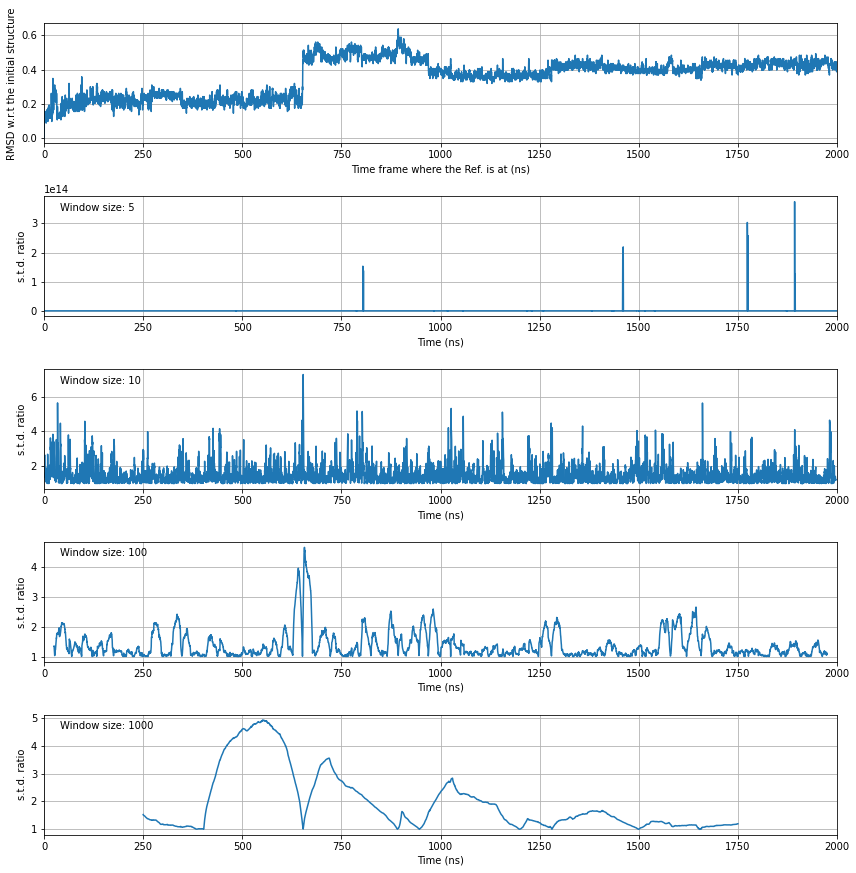

In [4]:
data = rmsd_1d[0]
w_size = [5, 10, 100, 1000]

plt.figure(figsize=(12, 12))

plt.subplot(5, 1, 1)
plt.plot(np.arange(8001) * 0.25, data)
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

for i in range(len(w_size)): 
    plt.subplot(5, 1, i + 2)
    std_ratio = calculate_std_ratio(data, w_size[i])
    plt.plot(np.arange(w_size[i], len(data) - w_size[i]) * 0.25, std_ratio)
    plt.xlabel('Time (ns)')
    plt.ylabel('s.t.d. ratio')
    plt.xlim([0, 2000])
    plt.text(0.02, 0.88, f'Window size: {w_size[i]}', transform=plt.gca().transAxes)
    plt.grid()
    
    t = (std_ratio.index(max(std_ratio)) + w_size[i]) * 0.25    # Note that for w=5, max(std_ratio) = inf, which is not plotted
    while t < 100:    # std_ratio could be high at the beginning, so we reject any case that t < 100 ns
        std_ratio.remove(max(std_ratio))
        t = (std_ratio.index(max(std_ratio)) + w_size[i]) * 0.25
    
    print(f'With the window size of {w_size[i]} data points, the location of the change point is at {t} ns.')

plt.tight_layout()

As shown above, if the window size is too small, the method tends to misidentify the change points and the results are noisy. On th other hand, if the window size is too large, the identified point will be much earlier than the point where the change actually happens (i.e. large error of the position of the change point). The window size being 100 looks reasonable in this case.

### Test case 2: 4EY9

However, the window size of 100 does not work eually well for all the cases because of different correlation times. For example, for 4EY9, we have the following results.

With the window size of 100 data points, the location of the change point is at 1600.25 ns.
With the window size of 250 data points, the location of the change point is at 578.0 ns.
With the window size of 500 data points, the location of the change point is at 565.0 ns.
With the window size of 1000 data points, the location of the change point is at 570.5 ns.


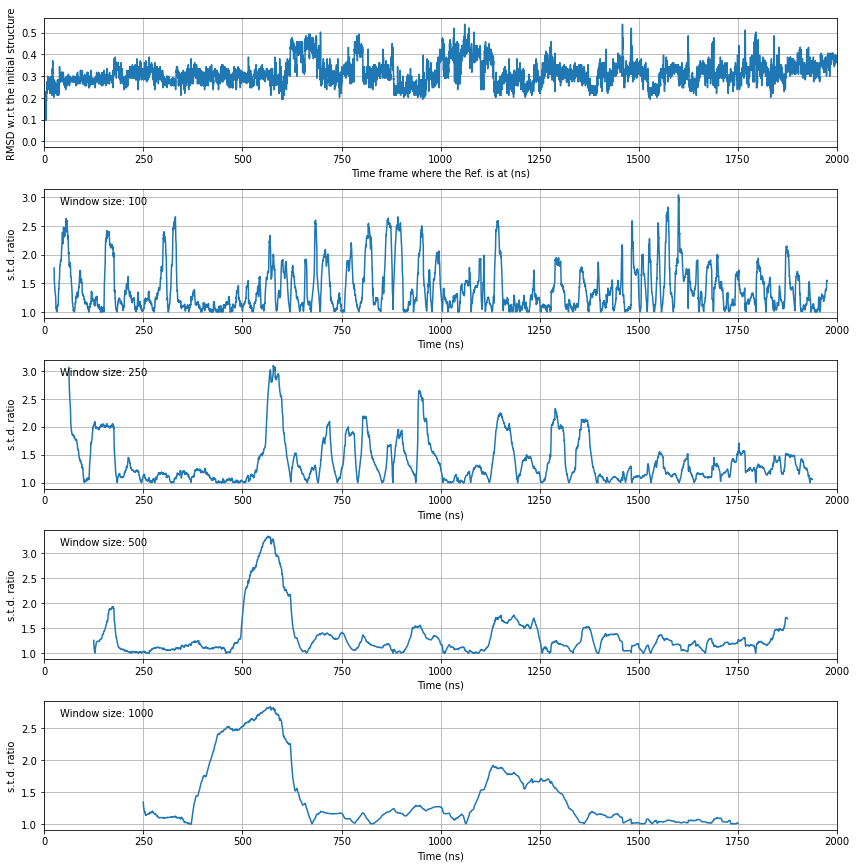

In [5]:
data = rmsd_1d[1]
w_size = [100, 250, 500, 1000]

plt.figure(figsize=(12, 12))

plt.subplot(5, 1, 1)
plt.plot(np.arange(8001) * 0.25, data)
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

for i in range(len(w_size)): 
    plt.subplot(5, 1, i + 2)
    std_ratio = calculate_std_ratio(data, w_size[i])
    plt.plot(np.arange(w_size[i], len(data) - w_size[i]) * 0.25, std_ratio)
    plt.xlabel('Time (ns)')
    plt.ylabel('s.t.d. ratio')
    plt.xlim([0, 2000])
    plt.text(0.02, 0.88, f'Window size: {w_size[i]}', transform=plt.gca().transAxes)
    plt.grid()
    
    t = (std_ratio.index(max(std_ratio)) + w_size[i]) * 0.25    # Note that for w=5, max(std_ratio) = inf, which is not plotted
    while t < 100:    # std_ratio could be high at the beginning, so we reject any case that t < 100 ns
        std_ratio.remove(max(std_ratio))
        t = (std_ratio.index(max(std_ratio)) + w_size[i]) * 0.25
    
    print(f'With the window size of {w_size[i]} data points, the location of the change point is at {t} ns.')

plt.tight_layout()

### Test case 3: 4EY1

With the window size of 300 data points, the location of the change point is at 1133.75 ns.
With the window size of 500 data points, the location of the change point is at 1650.0 ns.
With the window size of 800 data points, the location of the change point is at 1652.5 ns.
With the window size of 1000 data points, the location of the change point is at 1652.75 ns.


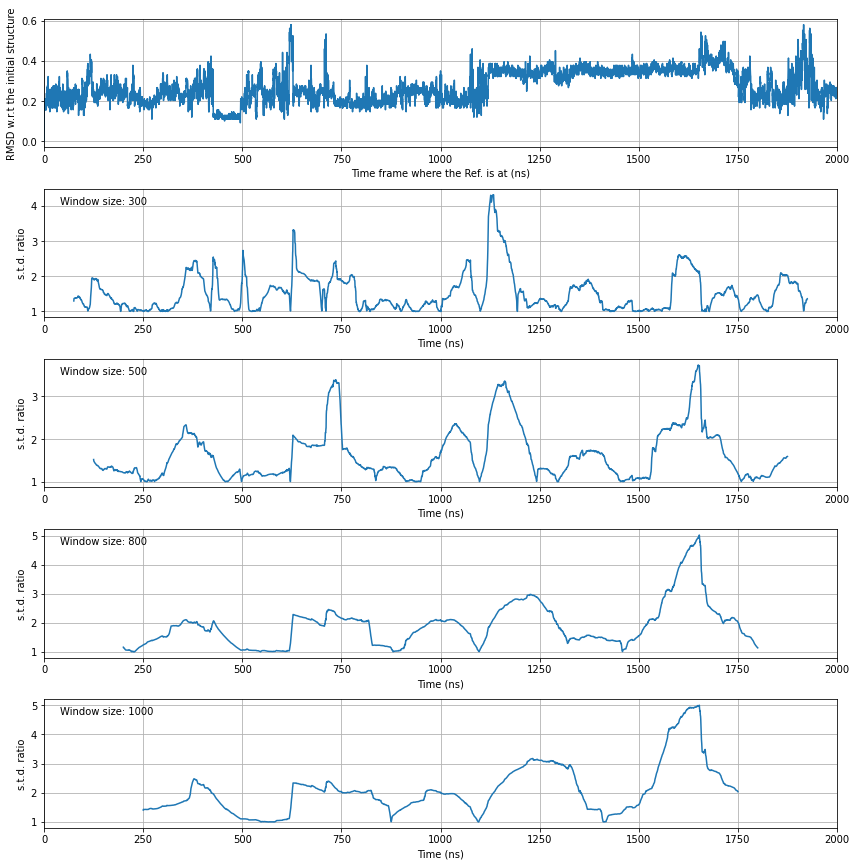

In [6]:
data = rmsd_1d[2]
w_size = [300, 500, 800, 1000]

plt.figure(figsize=(12, 12))

plt.subplot(5, 1, 1)
plt.plot(np.arange(8001) * 0.25, data)
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

for i in range(len(w_size)): 
    plt.subplot(5, 1, i + 2)
    std_ratio = calculate_std_ratio(data, w_size[i])
    plt.plot(np.arange(w_size[i], len(data) - w_size[i]) * 0.25, std_ratio)
    plt.xlabel('Time (ns)')
    plt.ylabel('s.t.d. ratio')
    plt.xlim([0, 2000])
    plt.text(0.02, 0.88, f'Window size: {w_size[i]}', transform=plt.gca().transAxes)
    plt.grid()
    
    t = (std_ratio.index(max(std_ratio)) + w_size[i]) * 0.25    # Note that for w=5, max(std_ratio) = inf, which is not plotted
    while t < 100:    # std_ratio could be high at the beginning, so we reject any case that t < 100 ns
        std_ratio.remove(max(std_ratio))
        t = (std_ratio.index(max(std_ratio)) + w_size[i]) * 0.25
    
    print(f'With the window size of {w_size[i]} data points, the location of the change point is at {t} ns.')

plt.tight_layout()

### Test case 4: 2MVC

Note that in this case, we need to set the constraint that t < 1000 ns to get a result more consistent with the plot of pairwise RMSD plot. 

With the window size of 50 data points, the location of the change point is at 1790.0 ns.
With the window size of 100 data points, the location of the change point is at 1446.0 ns.
With the window size of 200 data points, the location of the change point is at 1439.25 ns.
With the window size of 300 data points, the location of the change point is at 1408.5 ns.


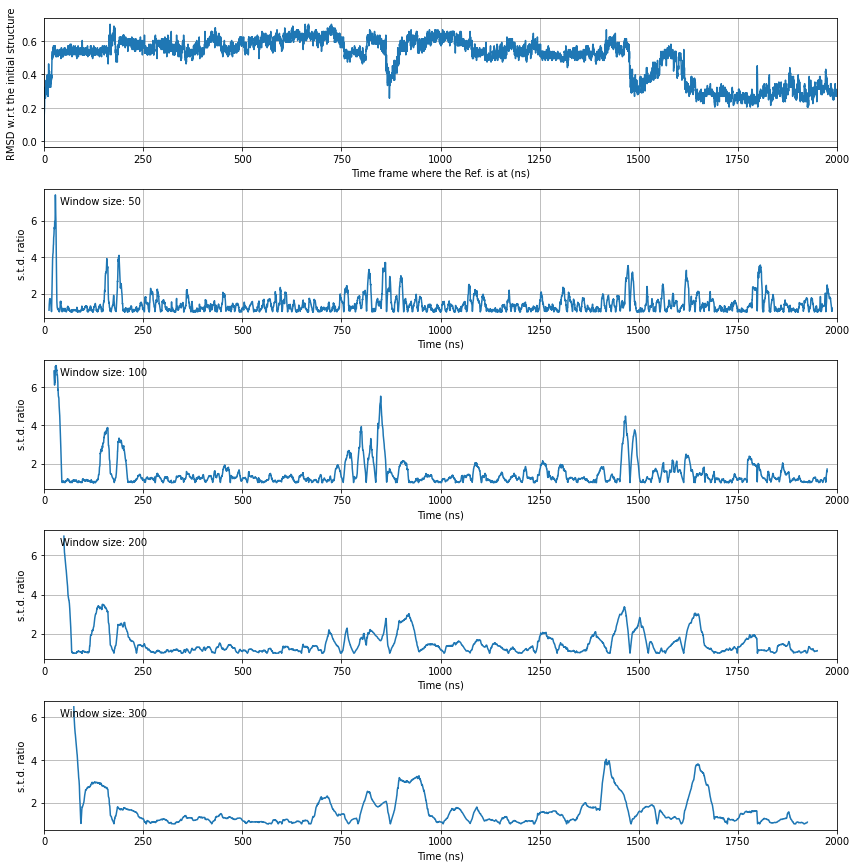

In [7]:
data = rmsd_1d[3]
w_size = [50, 100, 200, 300]

plt.figure(figsize=(12, 12))

plt.subplot(5, 1, 1)
plt.plot(np.arange(8001) * 0.25, data)
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

for i in range(len(w_size)): 
    plt.subplot(5, 1, i + 2)
    std_ratio = calculate_std_ratio(data, w_size[i])
    plt.plot(np.arange(w_size[i], len(data) - w_size[i]) * 0.25, std_ratio)
    plt.xlabel('Time (ns)')
    plt.ylabel('s.t.d. ratio')
    plt.xlim([0, 2000])
    plt.text(0.02, 0.88, f'Window size: {w_size[i]}', transform=plt.gca().transAxes)
    plt.grid()
    
    t = (std_ratio.index(max(std_ratio)) + w_size[i]) * 0.25    # Note that for w=5, max(std_ratio) = inf, which is not plotted
    while t < 1000:    # std_ratio could be high at the beginning, so we reject any case that t < 100 ns
        std_ratio.remove(max(std_ratio))
        t = (std_ratio.index(max(std_ratio)) + w_size[i]) * 0.25
    
    print(f'With the window size of {w_size[i]} data points, the location of the change point is at {t} ns.')

plt.tight_layout()

Clearly, for some cases, Method 1 did not work very well regardless of the window size, so we need a better method that is at least as good as visual inspection.

## Section 2: Offline CPD methods using `ruptures`
`rupture` is a package for offline CPD. Below are some relevant websites:
- GitHub repo: https://github.com/deepcharles/ruptures
- Documentation: https://centre-borelli.github.io/ruptures-docs/
- Tutorial: https://techrando.com/2019/08/14/a-brief-introduction-to-change-point-detection-using-python/

In [8]:
import ruptures as rpt
import time

Below we test out several offline CPD methods implemented in `ruptures`. As shown below, offline CPD methods seem to be very sensitive, so it might be better if we put contraints at the range of change point locations to locate the most obvious transition. Note that one of the advantages of offline CPD methods is that they are more accurate, since they consider the whole time series. Also note that PELT and dynamic programming methods are exact, which means that the results are not approximations.

### 1. PELT search method

The most likely change point location: 652.5, 681.25, 697.5 ns.
Elapsed time: 22.04 seconds.


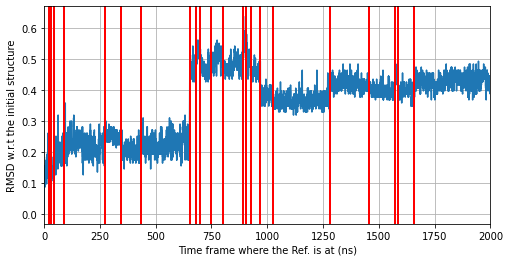

In [9]:
t1 = time.time()

data = rmsd_1d[0]   # 3i3z
algo = rpt.Pelt(model="rbf").fit(data)
change_loc = algo.predict(pen=10)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(8001) * 0.25, data)
for i in change_loc:
    plt.axvline(i * 0.25, lw=2, color='red')
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

locs = []
for i in change_loc:
    if i * 0.25 > 600 and i * 0.25 < 700:
        locs.append(i * 0.25)
        
loc_str = ', '.join([str(i) for i in locs])
print(f'The most likely change point location: {loc_str} ns.')
        
t2 = time.time()
print(f'Elapsed time: {t2 - t1:.2f} seconds.')

### 2. Binary sgementation search method

The most likely change point location: 652.5 ns.
Elapsed time: 0.43 seconds.


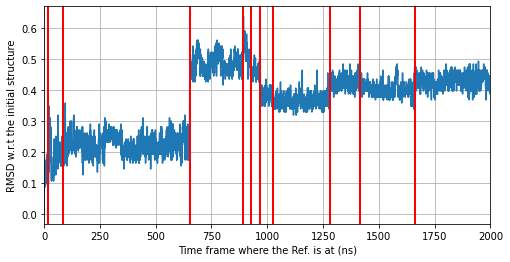

In [10]:
t1 = time.time()

data = rmsd_1d[0]   # 3i3z
algo = rpt.Binseg(model="l2").fit(data)
change_loc = algo.predict(n_bkps=10)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(8001) * 0.25, data)
for i in change_loc:
    plt.axvline(i * 0.25, lw=2, color='red')
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

locs = []
for i in change_loc:
    if i * 0.25 > 600 and i * 0.25 < 700:
        locs.append(i * 0.25)
        
loc_str = ', '.join([str(i) for i in locs])
print(f'The most likely change point location: {loc_str} ns.')
        
t2 = time.time()
print(f'Elapsed time: {t2 - t1:.2f} seconds.')

### 3. Window-based search method

The most likely change point location: 618.75, 652.5 ns.
Elapsed time: 0.20 seconds.


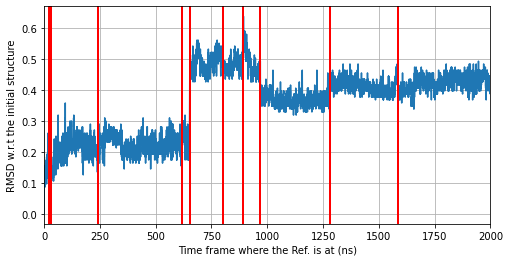

In [11]:
t1 = time.time()

data = rmsd_1d[0]   # 3i3z
algo = rpt.Window(width=40, model="l2").fit(data)
change_loc = algo.predict(n_bkps=10)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(8001) * 0.25, data)
for i in change_loc:
    plt.axvline(i * 0.25, lw=2, color='red')
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

locs = []
for i in change_loc:
    if i * 0.25 > 600 and i * 0.25 < 700:
        locs.append(i * 0.25)
        
loc_str = ', '.join([str(i) for i in locs])
print(f'The most likely change point location: {loc_str} ns.')
        
t2 = time.time()
print(f'Elapsed time: {t2 - t1:.2f} seconds.')

### 4. Dynamic programming search method

The most likely change point location: 652.5 ns.
Elapsed time: 138.96 seconds.


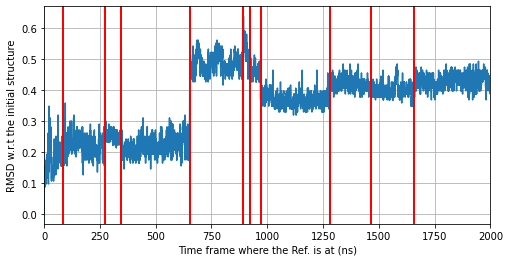

In [12]:
t1 = time.time()

data = rmsd_1d[0]   # 3i3z
algo = rpt.Dynp(model="l1", min_size=3, jump=5).fit(data)
change_loc = algo.predict(n_bkps=10)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(8001) * 0.25, data)
for i in change_loc:
    plt.axvline(i * 0.25, lw=2, color='red')
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

locs = []
for i in change_loc:
    if i * 0.25 > 600 and i * 0.25 < 700:
        locs.append(i * 0.25)
        
loc_str = ', '.join([str(i) for i in locs])
print(f'The most likely change point location: {loc_str} ns.')
        
t2 = time.time()
print(f'Elapsed time: {t2 - t1:.2f} seconds.')

### 5. Applying the binary segmentation search method to other cases

Overall, the window-based search method is the fastest and not too sensitive, so we apply it to other test cases below.

#### Test case: 4EY9

The most likely change point location: 621.25, 697.5 ns.
Elapsed time: 0.15 seconds.


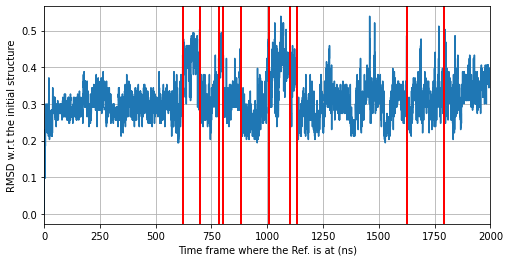

In [13]:
t1 = time.time()

data = rmsd_1d[1]   # 4ey9
algo = rpt.Window(width=40, model="l2").fit(data)
change_loc = algo.predict(n_bkps=10)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(8001) * 0.25, data)
for i in change_loc:
    plt.axvline(i * 0.25, lw=2, color='red')
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

locs = []
for i in change_loc:
    if i * 0.25 > 600 and i * 0.25 < 700:
        locs.append(i * 0.25)
        
loc_str = ', '.join([str(i) for i in locs])
print(f'The most likely change point location: {loc_str} ns.')
        
t2 = time.time()
print(f'Elapsed time: {t2 - t1:.2f} seconds.')

#### Test case: 4EY1

The most likely change point location: 1080.0, 1120.0 ns.
Elapsed time: 0.13 seconds.


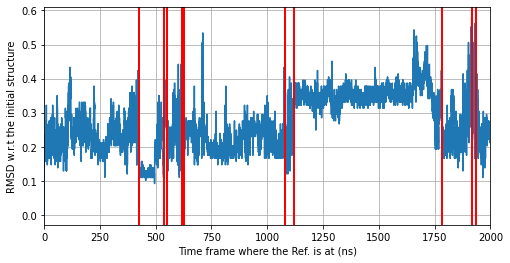

In [14]:
t1 = time.time()

data = rmsd_1d[2]   # 4ey1
algo = rpt.Window(width=40, model="l2").fit(data)
change_loc = algo.predict(n_bkps=10)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(8001) * 0.25, data)
for i in change_loc:
    plt.axvline(i * 0.25, lw=2, color='red')
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

locs = []
for i in change_loc:
    if i * 0.25 > 1000 and i * 0.25 < 1200:
        locs.append(i * 0.25)
        
loc_str = ', '.join([str(i) for i in locs])
print(f'The most likely change point location: {loc_str} ns.')
        
t2 = time.time()
print(f'Elapsed time: {t2 - t1:.2f} seconds.')

#### Test case: 2MVC

The most likely change point location: 1477.5 ns.
Elapsed time: 0.15 seconds.


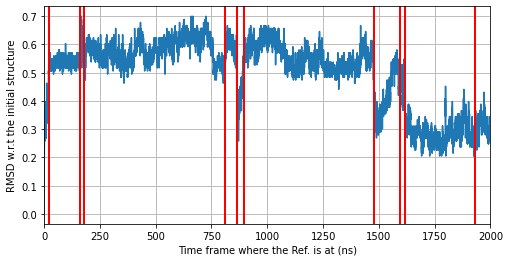

In [15]:
t1 = time.time()

data = rmsd_1d[3]   # 2mvc
algo = rpt.Window(width=40, model="l2").fit(data)
change_loc = algo.predict(n_bkps=10)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(8001) * 0.25, data)
for i in change_loc:
    plt.axvline(i * 0.25, lw=2, color='red')
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

locs = []
for i in change_loc:
    if i * 0.25 > 1450 and i * 0.25 < 1500:
        locs.append(i * 0.25)
        
loc_str = ', '.join([str(i) for i in locs])
print(f'The most likely change point location: {loc_str} ns.')
        
t2 = time.time()
print(f'Elapsed time: {t2 - t1:.2f} seconds.')

## Method 3: SDAR method using the `changefinder` module

Unlike `ruptures`, `changefinder` is a package for online CPD, which is generally faster than the offline analogues.
Here is a useful tutorial: https://www.kaggle.com/caesarlupum/anomaly-detection-time-series-changefinder

In [16]:
import changefinder

## Test case 1: 3I3Z

The transition happened at 652.75 ns.


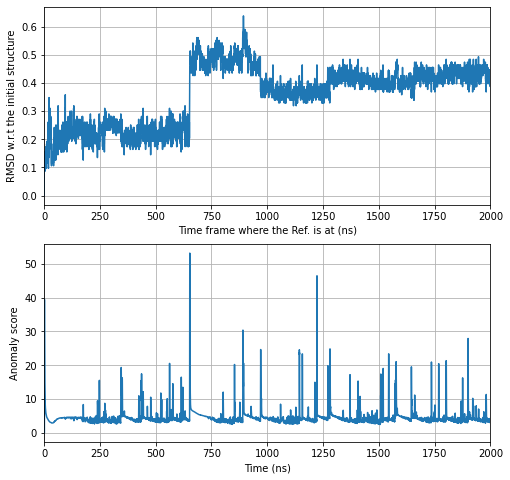

In [17]:
data = rmsd_1d[0]   # 3i3z

r = 0.01        # discounting rate (high r: the past time series decreases quickly -> less learning from the past)
order = 1       # AR model order
smooth = 5    # smoothing window size
cf = changefinder.ChangeFinder(r, order, smooth)
#cf = changefinder.ChangeFinder()
score = [cf.update(p) for p in data]

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(np.arange(8001) * 0.25, data)
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(data)) * 0.25, score)
plt.xlabel('Time (ns)')
plt.ylabel('Anomaly score')
plt.xlim([0, 2000])
plt.grid()

t = score.index(max(score)) * 0.25
print(f'The transition happened at {t} ns.')

## Test case 2: 4EY9

The transition happened at 627.25 ns.


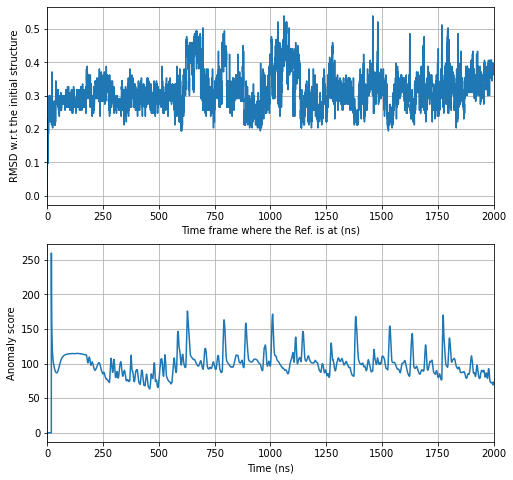

In [18]:
data = rmsd_1d[1]   # 4ey9

r = 0.01        # discounting rate (high r: the past time series decreases quickly -> less learning from the past)
order = 1       # AR model order
smooth = 50    # smoothing window size
cf = changefinder.ChangeFinder(r, order, smooth)
#cf = changefinder.ChangeFinder()
score = [cf.update(p) for p in data]

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(np.arange(8001) * 0.25, data)
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(data)) * 0.25, score)
plt.xlabel('Time (ns)')
plt.ylabel('Anomaly score')
plt.xlim([0, 2000])
plt.grid()

t = score.index(max(score)) * 0.25
while t < 100:
    score.remove(max(score))
    t = score.index(max(score)) * 0.25
print(f'The transition happened at {t} ns.')

## Test case 3: 4EY1

The transition happened at 1075.5 ns.


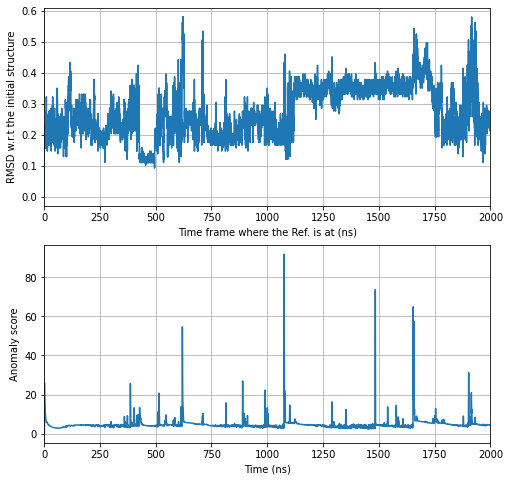

In [19]:
data = rmsd_1d[2]   # 4ey9

r = 0.005        # discounting rate (high r: the past time series decreases quickly -> less learning from the past)
order = 1       # AR model order
smooth = 5    # smoothing window size
cf = changefinder.ChangeFinder(r, order, smooth)
#cf = changefinder.ChangeFinder()
score = [cf.update(p) for p in data]

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(np.arange(8001) * 0.25, data)
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(data)) * 0.25, score)
plt.xlabel('Time (ns)')
plt.ylabel('Anomaly score')
plt.xlim([0, 2000])
plt.grid()

t = score.index(max(score)) * 0.25
print(f'The transition happened at {t} ns.')

## Test case 4: 2MVC

The transition happened at 1481.25 ns.


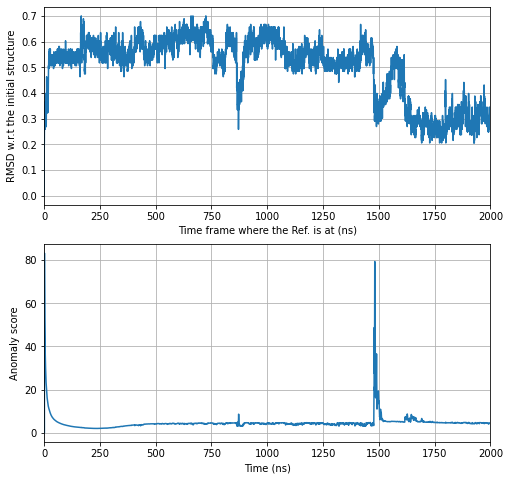

In [20]:
data = rmsd_1d[3]   # 4ey9

r = 0.001        # discounting rate (high r: the past time series decreases quickly -> less learning from the past)
order = 1       # AR model order
smooth = 5    # smoothing window size
cf = changefinder.ChangeFinder(r, order, smooth)
#cf = changefinder.ChangeFinder()
score = [cf.update(p) for p in data]

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(np.arange(8001) * 0.25, data)
plt.xlabel('Time frame where the Ref. is at (ns)')
plt.ylabel('RMSD w.r.t the initial structure')
plt.xlim([0, 2000])
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(data)) * 0.25, score)
plt.xlabel('Time (ns)')
plt.ylabel('Anomaly score')
plt.xlim([0, 2000])
plt.grid()

t = score.index(max(score)) * 0.25
while t < 100:
    score.remove(max(score))
    t = score.index(max(score)) * 0.25
print(f'The transition happened at {t} ns.')

As shown above, the method generally works well if the transition is clear with a generally small r values (so the past time series is more learned). For 4EY9, the data itself was nosier, so a larger window generally works better (to smooth out the noise). Notably, SDAR is an online CPD method, so it's generally less accurate the the ones shown in Section 2.

Lastly, below we summarize the best results we could get from each method for the 3I3Z model.

|        Method       | Change point |
|:-------------------:|:---------------------:|
|      STD ratio      |        653.5 ns       |
|         PELT        |        652.5 ns       |
| Binary segmentation |        652.5 ns       |
|     Window-based    |        652.5 ns       |
| Dynamic programming |         652.5         |
|         SDAR        |         652.75        |

Also, we concluded the change point location for each wild-type model as follows:

| WT model | Change point |             Method            |
|:--------:|:------------:|:-----------------------------:|
|   4EY9   |   621.25 ns  | PELT and window-based methods |
|   4EY1   |   1120.0 ns  |    All offline CPD methods    |
|   3I3Z   |   652.5 ns   |    All offline CPD methods    |
|   2MVC   |   1477.5 ns  |    All offline CPD methods    |